# Stability of Flat lamp in elp NRES

For a series of daylt flat field calibrations for elp:nres02 we measure the background and at a selected lcoation the flux in the arc flat field trace and the object flat field trace. 

The Tungsten lamp illuminates the arc trace via a fiber feed originating outside the thermal enclosure and is  fed via a beamsplitter / fiber into the spectrograph.

The trace on the object fiber receives the light via a fiber fed outside the igloo, to the AGU at the telscope, illuminating the AGU pinhole, and back into the spectrograph.

Having noticed variations in the illumination levels of the object trace, as well as slight movement of the AGU pinhole over a month, we investigate the stability of the illumination level in the arc and object fiber as a proxy for any alignemnt instabilities. 


In [2]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import glob
import tarfile
import tempfile
import os
import os.path
import PyPDF2
import re
import shutil
from astropy.io import fits
from astropy.time import Time
from astropy.io import ascii
import scipy.stats

from astroquery.simbad import Simbad
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

We study all nres02 data from Oct 2017

In [176]:
from scipy import ndimage
def getarcPosition (inputfilename):
    hdulist = fits.open (inputfilename)
    hdu = hdulist[1]
    objects = hdu.header['OBJECTS']
    dateobs = Time(hdu.header['DATE-OBS'], format='isot', scale='utc').datetime
    data = hdu.data
    hdulist.close() 
    
    background = data[3825:3925,100:400]
    background = np.mean ( background[np.abs (background - np.median(background) < 50)])
    if 'elp' in inputfilename:
        arclet = data[ 679-10:679+10, 3817-10:3817 +10] - background
    elif 'lsc' in inputfilename:
        arclet = data[ 2088-10:2088+10, 2304-10:2304 +10] - background
        
    center = ndimage.measurements.center_of_mass(arclet)
    return dateobs, center[0], center[1]

In [177]:
site = 'lsc'
nres = 'nres01'
inputfiles = []
for month in ('08','09','10',):
    flattemplate = "/nfs/archive/engineering/%s/%s/2017%s??/raw/%s*e00*.fits.fz" % (site,nres, month,site)
    inputfiles.append (glob.glob (flattemplate))
inputfiles = [item for sublist in inputfiles for item in sublist]

dates = []
ys = []
xs = []

for image in inputfiles:
    date,y,x = getarcPosition (image)
    dates.append (date)
    xs.append (x)
    ys.append (y)

dates = np.asarray(dates)
xs = np.asarray(xs)
ys = np.asarray (ys)

In [187]:
print dates.shape, xs.shape, ys.shape

(1407,) (1407,) (1407,)


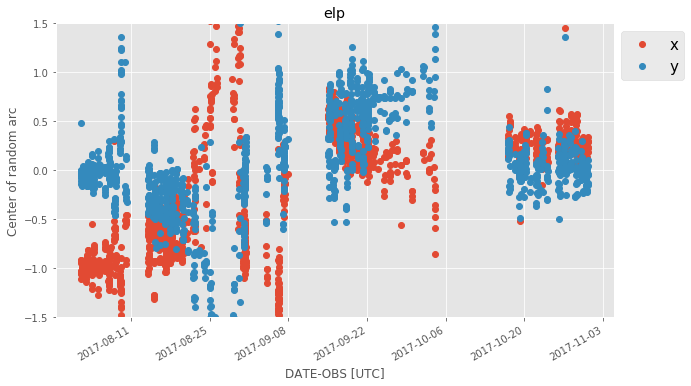

In [197]:
plt.figure()
plt.plot (dates, xs - np.nanmedian(xs), "o", label="x")
plt.plot (dates, ys - np.nanmedian(ys), "o", label="y")

lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.gcf().autofmt_xdate()
plt.xlabel ("DATE-OBS [UTC]")
plt.ylabel ("Center of random arc")
plt.ylim ([-1.5,1.5])
plt.title ('elp')
#plt.savefig ("nres_arcstability-elp.png", box_extra_artists=(lgd,), bbox_inches="tight", dpi=300)
plt.savefig ("nres_arcstability-lsc.png", box_extra_artists=(lgd,), bbox_inches="tight", dpi=300)

In [24]:
def getFluxInFlat (inputfilename):
    """
      Extract the background level and sum the flux in selected rectangles placed on the object and arc traces. 
    """
    
    hdulist = fits.open (inputfilename)
    hdu = hdulist[1]
    objects = hdu.header['OBJECTS']
    
    if ('elp' in inputfilename) & ('tung&tung&none' not in objects):
        return (None, None, None)
    
    if ('lsc' in inputfilename) & ('tung&tung&none' not in objects):
        return (None, None, None)
    
    
    dateobs = Time(hdu.header['DATE-OBS'], format='isot', scale='utc')
    data = hdu.data
    hdulist.close()    
    background = data[3825:3925,100:400]
    background = np.mean ( background[np.abs (background - np.median(background) < 50)])
        
    if 'elp' in inputfilename:
           
        arcflat = data[1865:1885 , 2200:2250] - background
        objflat = data[1888:1908 , 2200:2250] - background
    elif 'lsc in inputfilename' :
        arcflat = data[1887:1907 , 2200:2250] - background
        objflat = data[1909:1929 , 2200:2250] - background
        
        
    arcflat = np.sum (arcflat)
    objflat = np.sum (objflat)
      
    #print ("%s %s %s %s" % (inputfilename, dateobs, arcflat, objflat))
    return dateobs,arcflat,objflat
    
    

In [77]:
site = 'elp'
nres = 'nres02'
inputfiles = []
for month in ('10',):
    flattemplate = "/nfs/archive/engineering/%s/%s/2017%s??/raw/%s*w00*.fits.fz" % (site,nres, month,site)
    inputfiles.append (glob.glob (flattemplate))
inputfiles = [item for sublist in inputfiles for item in sublist]

# We calculate flux in arc and object trace for a all files selcted above. 

dateobs = []
arcflux= []
objflux = []

for infile in inputfiles:
    (do, af, of) =  getFluxInFlat (infile)
    if do is None:
        continue
        
    dateobs.append (do.datetime)
    arcflux.append (af)
    objflux.append (of)


dateobs = np.asarray(dateobs)
arcflux = np.asarray(arcflux)
objflux = np.asarray(objflux)

ascii.write([dateobs,arcflux, objflux], 'arclampstatistics_%s.dat' % site, overwrite=True)


In [26]:

ascii.write([dateobs,arcflux, objflux], 'arclampstatistics_lsc.dat')

In [140]:
%matplotlib inline
# plot the result: First, in abolsute terms, then as the ratio between the object trace flux and the more stable
# arc trace

def plotforsite (datafile, site):

    data = ascii.read (datafile)
    
    dateobs =  Time(data['col0'], format='iso', scale='utc').datetime
    arcflux = data['col1']
    objflux = data['col2']
     
    plt.figure()
    plt.plot (dateobs, objflux, "o", label="Flux in obj trace")
    plt.plot (dateobs, arcflux, "o", label="Flux in arc trace")

    lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
    plt.gcf().autofmt_xdate()
    plt.xlabel ("DATE-OBS [UTC]")
    plt.ylabel ("Flux sum in arc and obj trace [ADU]")
    
    plt.title (site)
    plt.savefig ("nres_lampstability-%s.png" % site, box_extra_artists=(lgd,), bbox_inches="tight", dpi=300)


    plt.figure()
    ratio = objflux / arcflux
    ratio = ratio /  np.median (ratio)
    plt.plot (dateobs, ratio , "o", label="Flux ratio obj / arc trace / meanRatio")
    lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
    plt.gcf().autofmt_xdate()
    plt.xlabel ("DATE-OBS [UTC]")
    plt.ylabel ("Ratio of fluxes in arc and obj trace")
    plt.title (site)
    plt.ylim([0.5,1.5])

    plt.savefig ("nres_lampstability_ratio-%s.png" % site, box_extra_artists=(lgd,), bbox_inches="tight", dpi=300)

    


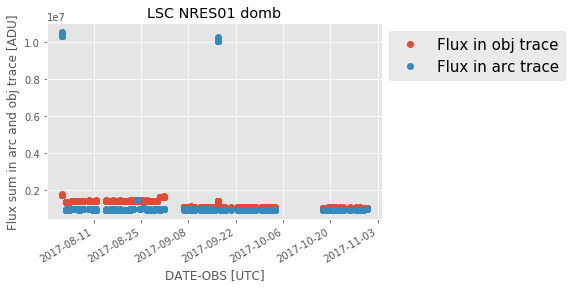

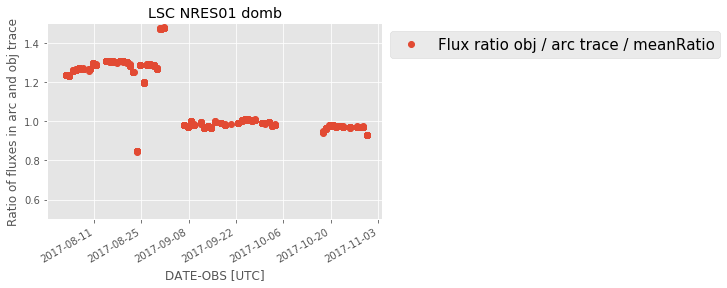

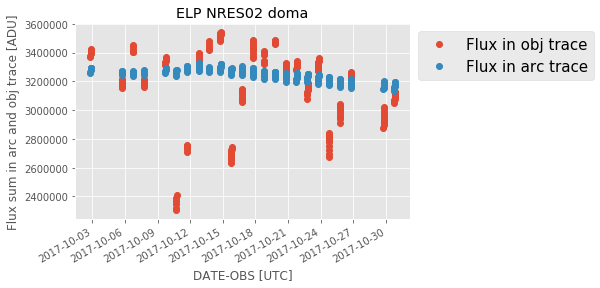

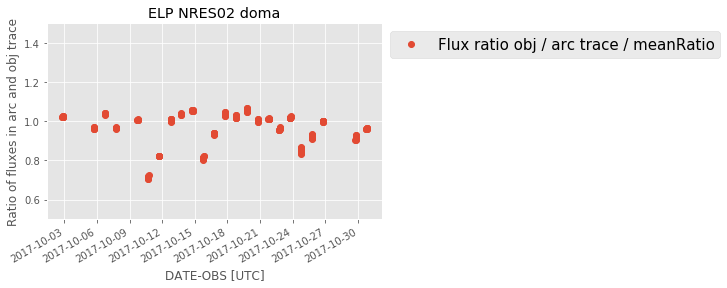

In [141]:
plotforsite ('arclampstatistics_lsc.dat', "LSC NRES01 domb")
plotforsite ('arclampstatistics_elp.dat', "ELP NRES02 doma")

# Conclusion
Both arc and object trace fluxes show a ramp up in flux during the about one hour long flat acqusition. On tob of the intra day varaition, the object flat arc varies signficantly (by up to 30 %), 5% more typical. the origin and impact on calibration is not yet clear. Also, comparison with lsc:nres01 is pending. 

Correlation with temperature and or / daylight (sun / clouds, with stray light entering dome / AGU) might be possibilities. 

In [175]:
# make catalog of all pin hole images
import scipy.misc

allak04 = glob.glob ('/nfs/archive/engineering/elp/ak04/*/raw/*.fz')

#os.makedirs('temp')

for imagename in allak04:
    image = fits.open(imagename)
    extractdata = image[1].data[490:536,630:680]

    outname = '%s/%s.fits' % ('temp',os.path.basename(imagename)[:-3])
    hdu = fits.PrimaryHDU(extractdata)
    hdu.header['OBJECT'] = image[1].header['OBJECT']
    hdu.header['DATE-OBS'] = image[1].header['DATE-OBS']
    hdu.header['EXPTIME'] = image[1].header['EXPTIME']
    hdu.writeto (outname)
    del hdu
    image.close
    
    
    #scipy.misc.toimage(extractdata, cmin=300, cmax=np.max(extractdata)).save(outname)
    

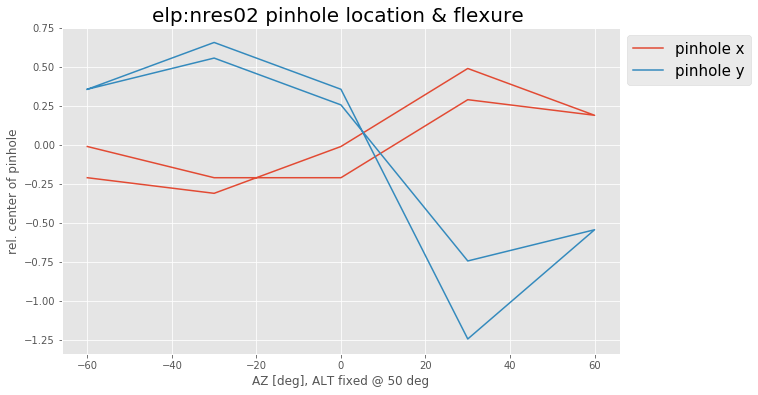

In [16]:
data = np.genfromtxt ('elpflex.txt', unpack=True)

plt.plot (data[0],data[1] - np.mean (data[1]), label="pinhole x")
plt.plot (data[0],data[2] - np.mean (data[2]), label="pinhole y")
lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.xlabel ('AZ [deg], ALT fixed @ 50 deg')
plt.ylabel ('rel. center of pinhole')
plt.title  ('elp:nres02 pinhole location & flexure ', fontsize=20)
plt.savefig ("nres_elp_flexure_AZ.png", box_extra_artists=(lgd,), bbox_inches="tight", dpi=300)